# BIS Central Bank Policy Rate data

Note: the BIS database typically only updates weekly, and it can take some weeks for it to capture rate rises. The footnotes in the individual national charts show the date of the latest data for that nation held at the BIS.

## Python setup

### Imports

In [1]:
# analytic imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# system imports
from pathlib import Path
from datetime import date

# local imports
from plotting import (
    finalise_plot, 
    set_chart_dir,
    plot_series_highlighted,
)
from bis_data_capture import get_bis_cbpr

In [2]:
# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# plotting stuff
plt.style.use('fivethirtyeight')

# Where to put the charts
CHART_DIR = "./charts/BIS"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
set_chart_dir(CHART_DIR)

# Remove old charts
for filename in Path(CHART_DIR).glob("*.png"):
    filename.unlink()

## Central Bank Policy Data/Charts

### Get Bank for International Settlements (BIS) Data

In [3]:
bis_meta, bis_data = get_bis_cbpr()

In [4]:
#bis_data['Australia'].tail(30)

### Plot individual central bank policy rates over the recent past

In [5]:
RECENT = pd.Period('2017-12-31')
data_r = bis_data[bis_data.index >= RECENT]
for nation in data_r.columns:
    national_series = data_r[nation]
    last_valid = national_series.last_valid_index()
    national_series = national_series[national_series.index <= last_valid]
    ax = national_series.ffill().plot(lw=2, drawstyle='steps-post',)
    title = f'Central Bank Policy Rate for {nation}'
    finalise_plot(
        ax, title=title, 
        ylabel='Per cent', 
        rfooter=f'Data source: BIS as at {last_valid}',
        # show=True,
    )

### Look at tightening cycles

In [6]:
# Central banks started adopted an inflation-targeting
# approaches in the late 1980s and early 1990s.
# This is usually marked by less frequent changes to the policy rate
# with thos changes being in the order of 0.1 of a percentage point or higher.

STANDARD_FROM = '1993-01-01' 
FROM_1999 = '1999-07-01'
FROM_1998 = '1998-07-01'

odd_start = {
    # late adoption of infrequent (ie. <= monthly) changes to rates
    # or for other reasosn we exclude earlier data 
    'Denmark': FROM_1998,
    'Hong Kong SAR': '1998-09-01', 
    
    'Chile': FROM_1999,
    'Czechia': FROM_1999,
    'New Zealand':  FROM_1999,
    'Israel': FROM_1999,
    'Malaysia': FROM_1999,
    'Poland': FROM_1999,
    'India': FROM_1999,
    
    'Canada': '1996-07-01',
    'Norway': '1995-01-01',
    'Sweden': '1994-01-01',
    'Brazil': '2000-01-01',
    'Switzerland': '1992-01-01',
    'Russia': '2002-01-01', 
}

ignore = {'Argentina', 'Croatia', 'North Macedonia',
          'Mexico', 'Serbia', 'Philippines', }
show_please = ('Australia', 'United States', 'Canada', 'New Zealand', 'United Kingdom')

for nation in bis_data.columns:
    
    if nation in ignore:
        continue
    
    selected = bis_data[nation].dropna()
    to_date = selected.index[-1]
    from_date = STANDARD_FROM if nation not in odd_start.keys() else odd_start[nation]
    selected = selected[selected.index >= from_date]

    # The Australian data has some odd rounding for some dates
    # roughly in the order of a few 1/1000 of a percent. 
    # Lets force all the data to be in whole basis points. 
    selected = (selected * 100).round(0) / 100

    ax = plot_series_highlighted(selected, threshhold=0.001)
    finalise_plot(
        ax, 
        title=f'Central Bank Policy Rate - {nation} - Tightening Cycles', 
        ylabel='Per cent', 
        rfooter=f'Data source: BIS as at {to_date}',
        #show=nation in show_please,
    )

### Summary charts - from 2021 Covid until now

In [7]:
# get central bank policy movement
KEY_DATE = '2021-01-01'
MID_COVID = pd.Period(KEY_DATE, freq='D')
PLUS_MINUS = 180 
minima = bis_data.ffill()[
    (bis_data.index >=  MID_COVID - PLUS_MINUS)
    & (bis_data.index <=  MID_COVID + PLUS_MINUS)
].min()
current = bis_data.ffill().iloc[-1]
movement = current - minima

# dropping Argentina because the movement is so large.
movement = movement.drop('Argentina').sort_values()

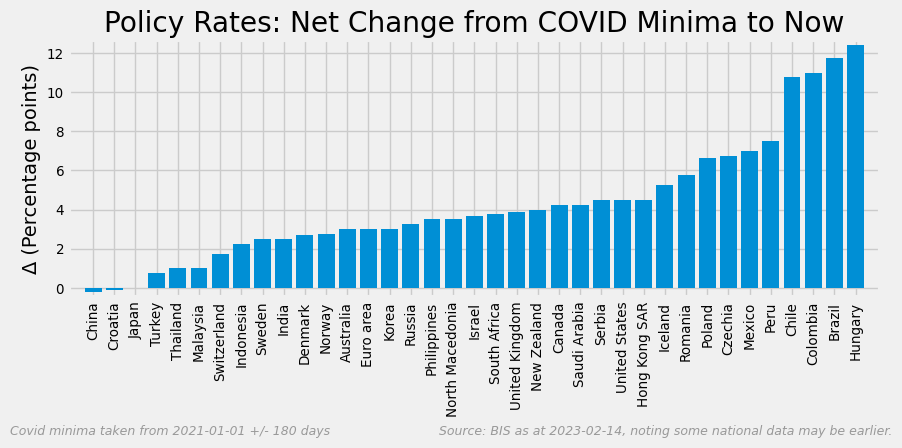

In [8]:
# plot
ax = movement.plot.bar(width=0.8)
ax.tick_params(axis='both', which='major', labelsize='x-small')
ax.set_ylabel('Δ (Percentage points)', fontsize='medium')
title = 'Policy Rates: Net Change from COVID Minima to Now'
finalise_plot(
        ax, title=title, 
        ylabel='Δ (Percentage points)', 
        rfooter=f'Source: BIS as at {bis_data.index[-1]}, '
                'noting some national data may be earlier.',
        lfooter=f'Covid minima taken from {KEY_DATE} +/- {PLUS_MINUS} days',
        show=True,
    )

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_11097/2204199939.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels, rotation = 90)


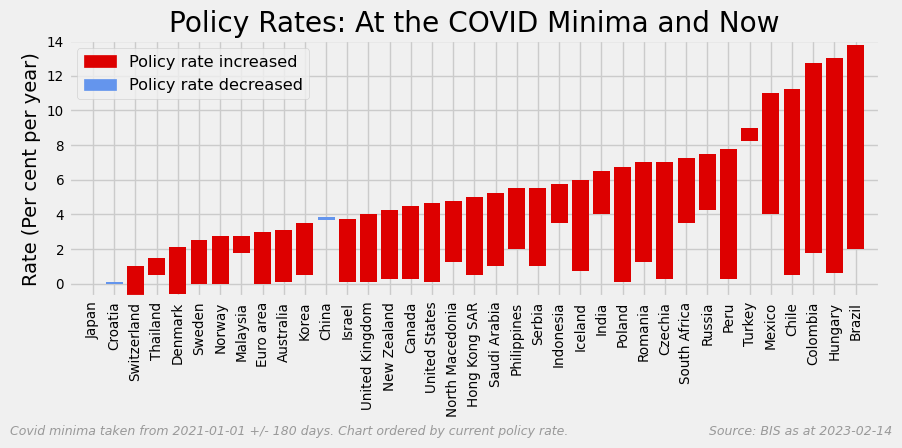

In [9]:
# plot in a candlestick style
curr = current.drop('Argentina').sort_values()
mini = minima[curr.index]
xticklabels = curr.index.to_list()

up, down = '#dd0000','cornflowerblue' 
colours = [up if c > m else down for c, m in zip(curr, mini)]
height = (mini - curr).abs()
bottom = pd.DataFrame([curr, mini]).min()

fig, ax = plt.subplots()
ax.bar(
    x=xticklabels,
    height=height,
    bottom=bottom,
    color=colours
)
ax.set_xticklabels(xticklabels, rotation = 90)
ax.tick_params(axis='both', which='major', labelsize='x-small')
ax.set_ylabel('Rate (Per cent per year)', fontsize='medium')

up_patch = mpatches.Patch(color=up, label='Policy rate increased')
down_patch = mpatches.Patch(color=down, label='Policy rate decreased')
ax.legend(handles=[up_patch, down_patch], loc='best', fontsize='small')

title = 'Policy Rates: At the COVID Minima and Now'
finalise_plot(
        ax, title=title, 
        ylabel='Rate (Per cent per year)', 
        rfooter=f'Source: BIS as at {bis_data.index[-1]}',
        lfooter=f'Covid minima taken from {KEY_DATE} +/- {PLUS_MINUS} days. '
                'Chart ordered by current policy rate.',
        show=True,
    )

## Tables of recent rate increases by nation

In [10]:
if False: # but only if needed ...

    POST_COVID = '2021-09-01'

    of_interest = [
        'Australia', 'Euro area', 'United States',
        'Canada', 'New Zealand', 'United Kingdom',
    ]

    for k in of_interest:
        series = bis_data[k]
        to_date = series.last_valid_index()
        print('\n', k, to_date)
        series = series.ffill()[series.index >= POST_COVID].dropna()
        table = pd.DataFrame([series[series.diff() != 0], series.diff()[series.diff() != 0]],
                             index=['Rate', 'Change']).T
        table.index.name = 'Date'
        print(table.to_csv())

## Finished

In [11]:
%reload_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Tue Feb 21 2023 22:29:41

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.10.0

matplotlib: 3.7.0
pandas    : 1.5.3

Watermark: 2.3.1



In [12]:
print('Done')

Done
